<a href="https://colab.research.google.com/github/lgvaz/mantisshrimp/blob/master/tutorials/02-how_train_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train a dataset
![](https://github.com/ai-fast-track/mantisshrimp/blob/fridge-tutorial/images/fridge-objects.png?raw=1)

## 1- Introduction

This tutorial walk you throug the different steps of training the fridge dataset. the Mantisshrimp Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) library.

## 2- Using Google Colab
First, enable the GPU runtime:  
`Runtime` -> `Change runtime type` -> `Hardware accelerator dropdown` -> `GPU`  

## 3- Packages Installations

In [ ]:
# Install Mantisshrimp package
!pip install git+git://github.com/ai-fast-track/mantisshrimp.git@fridge-tutorial

In [ ]:
# Install cocoapi and albumentations packages
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install albumentations --upgrade

In [ ]:
# Install fastai and/or Pytorch-Lightning
!pip install fastai2
!pip install pytorch-lightning

## 4- Imports

In [4]:
from mantisshrimp.imports import *
from mantisshrimp import *
from mantisshrimp.models.rcnn import faster_rcnn
from mantisshrimp.datasets.fridge.transforms import *

import albumentations as A

## 5- Datasets : Fridge Objects dataset
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

Mantisshrimp provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [ ]:
# load data, and create a Parser object
path = datasets.fridge.load()
parser = datasets.fridge.parser(path)

In [ ]:
# For convenience
CLASSES = datasets.fridge.CLASSES
# Create a splits for train and validation data
data_splitter = RandomSplitter([.8, .2])
# Create both train and validation records
train_records, valid_records = parser.parse(data_splitter)

<div class="alert alert-warning">

**Important**

A record is a dictionary that contains all parsed fields defined by the parser used. No matter what format the annotations used, a record has a common structure that can be connected to different DL frameworks (fastai, Pytorch-Lightning, etc.)

</div>

### 5.3- Visualization

Showing one single record (image + box + label)

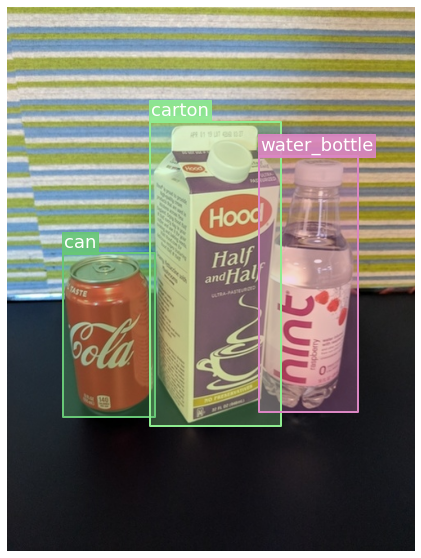

In [7]:
show_record(train_records[0], classes=CLASSES)

Showing a batch of images with their corresponding boxes and labels

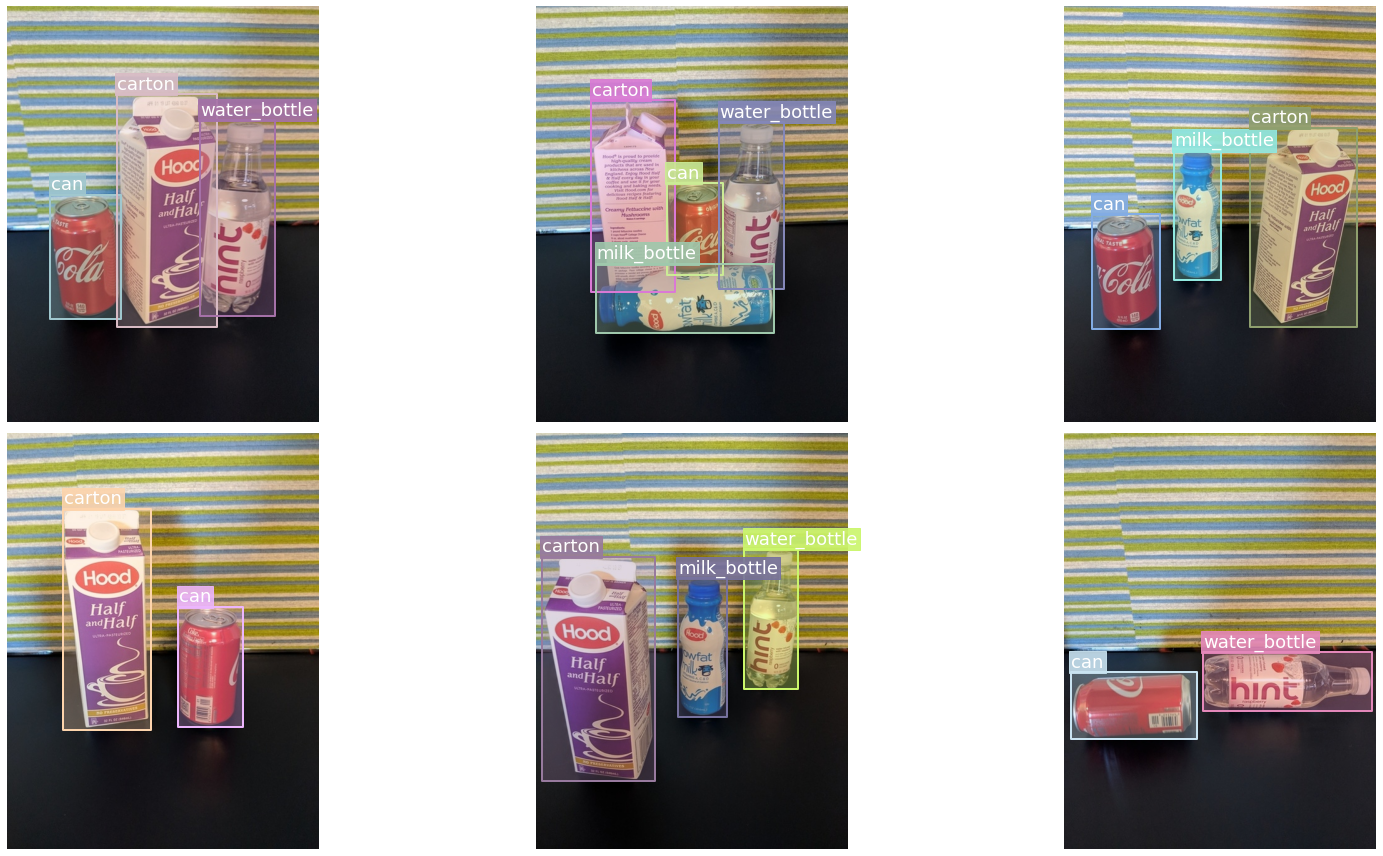

In [8]:
show_records(train_records[:6], ncols=3, classes=CLASSES)

### 5.4- Plot dataset height and width histogram

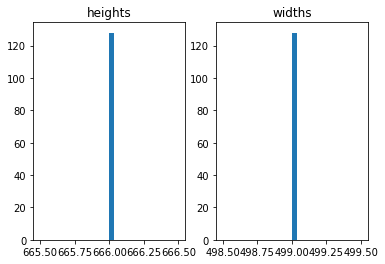

In [9]:
all_records = train_records + valid_records
_ = datasets.fridge.plot_size_histogram(all_records)

## 6- Train and Validation Dataset Transforms

## 7- Dataset

Not to be confused with our previous `datasets` module, `Dataset` is a class that combines the records and transforms.

For creating a `Dataset` we just need need to pass the parsed records from the previous step and optionally the transforms.


In [10]:
# Create both training and validation datasets - using Albumentations transforms out of the box
train_ds = Dataset(train_records, train_albumentations_tfms_fridge())
valid_ds = Dataset(valid_records, valid_albumentations_tfms_fridge())

<div class="alert alert-warning">
What a `Dataset` class  does:  
* Prepares the record: For example, in the record we just have a filename that points to the image, it's at this stage that we open the image. 
* Apply the pipeline of transforms to record processed in the previous step
</div>

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

### 7.1- Displaying the same image with different transforms

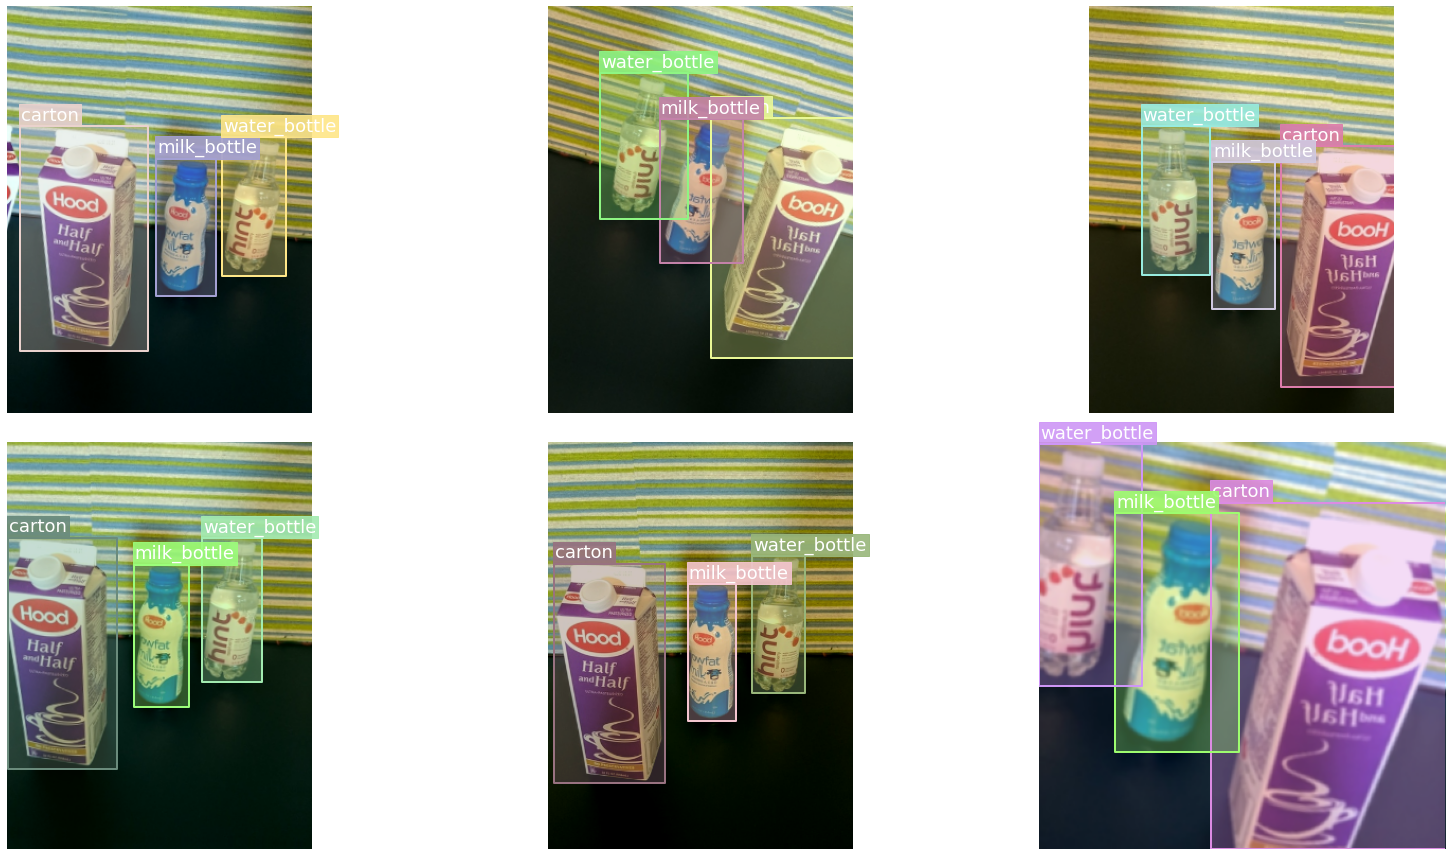

In [11]:
samples = [train_ds[4] for _ in range(6)]
show_samples(samples, ncols=3, classes=CLASSES, denormalize_fn=denormalize_imagenet)

## 8- DataLoader

In [12]:
# Create both training and validation dataloaders
train_dl = faster_rcnn.train_dataloader(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dataloader(valid_ds, batch_size=16, num_workers=4, shuffle=False)

## 9- Model

In [ ]:
# Using the FasterRCNN model 
model = faster_rcnn.model(num_classes= len(CLASSES))

## 10- Training

Mantisshrimp is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### 10.1- Training using fastai
For getting access to the helper functions to train with fastai, just `import` as follows:

In [14]:
# import fastai engine provided by the mantisshrimp modules
from mantisshrimp.engines.fastai import *

# Create a Learner object, and train the model
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model)

/usr/local/lib/python3.6/dist-packages/fastai2/callback/core.py:29: UserWarning: You are setting an attribute (loss) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.loss` if you would like to change it in the learner.
  warn(f"You are setting an attribute ({name}) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.{name}` if you would like to change it in the learner.")


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.4454397387453355e-05)

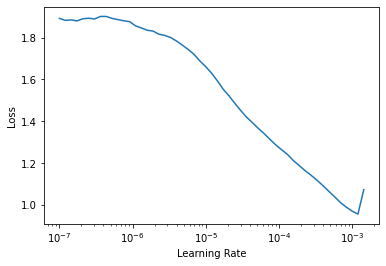

In [15]:
learn.lr_find()

In [17]:
learn.fine_tune(10, lr=1e-4)

### 10.1- Plotting losses

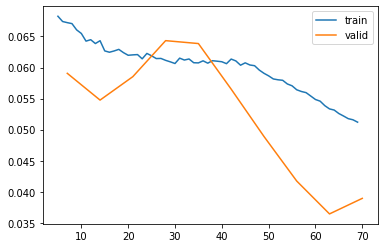

In [18]:
learn.recorder.plot_loss()

### 10.2- Training using Pytorch-Lightning

In [ ]:
# import lightning engine provided by the mantisshrimp modules
from mantisshrimp.engines.lightning import *

class LightModel(RCNNLightningAdapter):
    def configure_optimizers(self):
        opt = SGD(self.parameters(), 2e-4, momentum=0.9)
        return opt

In [ ]:
# Create a Trainer object, and train the model
light_model = LightModel(model)
trainer = Trainer(max_epochs=3, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## 11- Inference

### 11.2- Using our Trained Weights
If you don't want to train the model, you can use our rained weights that we publicly made vailable: You can download them with `torch.hub`:

In [ ]:
weights_url = "https://mantisshrimp-models.s3.us-east-2.amazonaws.com/fridge_faster_resnetfpn50.zip"
state_dict = torch.hub.load_state_dict_from_url(weights_url, map_location=torch.device("cuda"))

Let's recreate the model and load the downloaded weights:

In [20]:
model = faster_rcnn.model(num_classes= len(CLASSES))
model.load_state_dict(state_dict)

<All keys matched successfully>

### 11.3- Predicting all images at once

In [21]:
# Choosing some images
samples = random.choices(valid_ds, k=6)
images = [sample["img"] for sample in samples]

In [22]:
batch = faster_rcnn.build_infer_batch(images)
preds = faster_rcnn.predict(model=model, batch=batch, detection_threshold=.8)

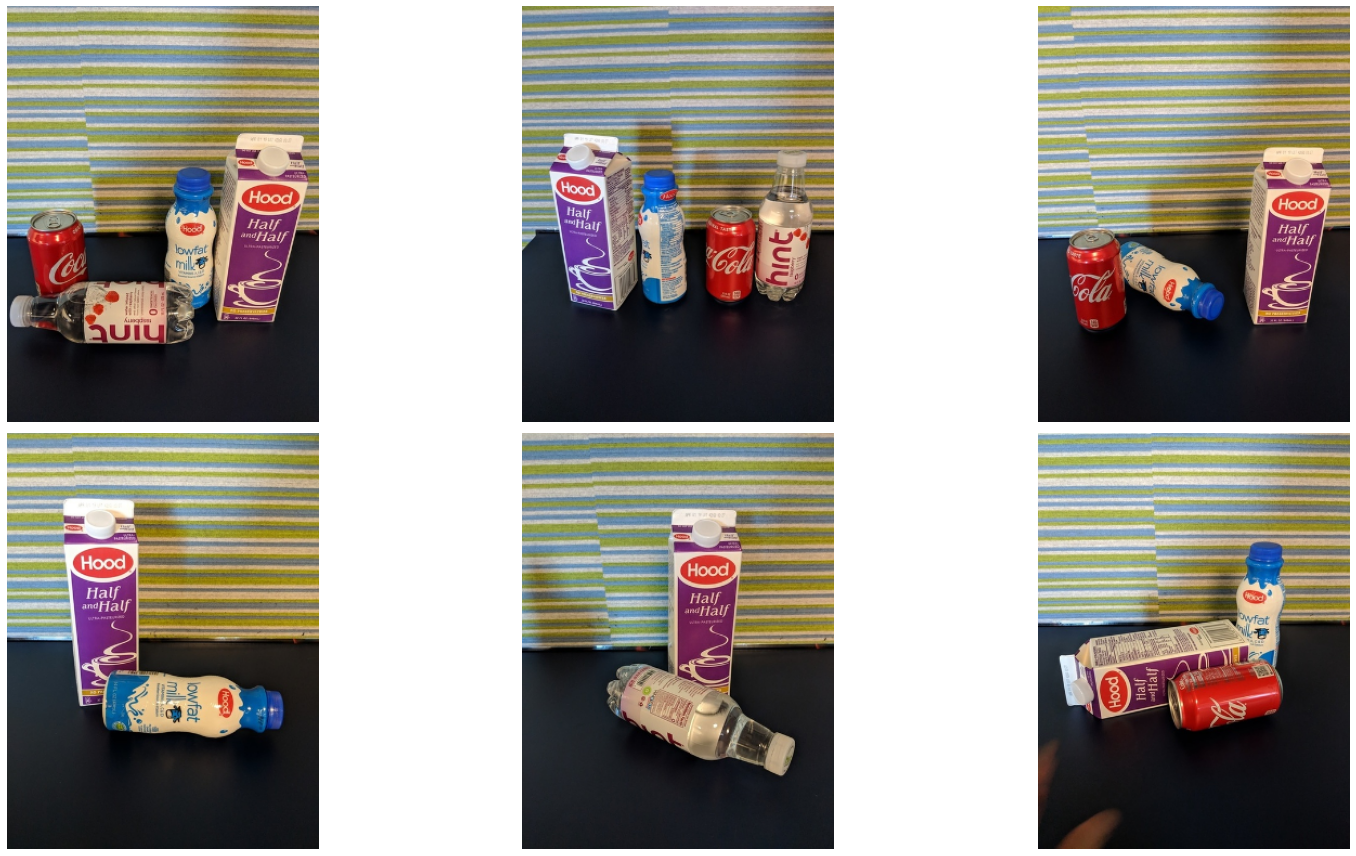

In [23]:
# Diplay a set of images with their corresponding predictions (boxes + labesl)
show_preds(images, preds, ncols=3, classes=CLASSES, denormalize_fn=denormalize_imagenet)

### 11.4- Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient. 

In [24]:
infer_dl = faster_rcnn.infer_dataloader(dataset=images, batch_size=8)

Using a simple iterator over the dataloader, we can make predictions for each batch:

In [25]:
preds = [faster_rcnn.predict(model=model, batch=batch) for batch in infer_dl]

In [ ]:
preds[0]

## Saving Model on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

In [28]:
torch.save(model.state_dict(), root_dir/'mantisshrimp/models/fridge/fridge_faster_resnetfpn50.pth')

## Happy Learning!

If you need any assistance, feel free to reach out at us [here](https://github.com/lgvaz/mantisshrimp/tree/master/mantisshrimp)